In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import pathlib
import glob

import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
import equinox as eqx
import optax


In [2]:
from mc2.utils.data_inspection import (
    get_available_material_names,
    get_file_overview,
    filter_file_overview,
    load_single_file,
    load_and_process_single_from_full_file_overview,
)
from mc2.utils.data_plotting import plot_single_sequence
from mc2.data_management import FrequencySet, MaterialSet, DataSet, NormalizedFrequencySet,load_data_into_pandas_df
from mc2.features.features_jax import add_fe

In [3]:
from mc2.training_jax.jax_routine import train_recursive_nn, train_model

#gpus = jax.devices()
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
#jax.config.update("jax_default_device", gpus[0])

In [4]:
from abc import ABC, abstractmethod
import numpy.typing as npt
class ModelInterface(eqx.Module):

    @abstractmethod
    def __call__(
        self,
        B_past: npt.NDArray[np.float64],
        H_past: npt.NDArray[np.float64],
        B_future: npt.NDArray[np.float64],
        T: npt.NDArray[np.float64],
        f: npt.NDArray[np.float64],
    ) -> npt.NDArray[np.float64]:
        """Model prediction interface for batched inputs, i.e. for inputs with an extra
        leading dimension.

        Args:
            B_past (np.array): The physical (non-normalized) flux density values from time
                step t0 to t1 with shape (n_batches, past_sequence_length)
            H_past (np.array): The physical (non-normalized) field values from time step
                t0 to t1 with shape (n_batches, past_sequence_length)
            B_future (np.array): The physical (non-normalized) flux density values from
                time step t1 to t2 with shape (n_batches, future_sequence_length)
            T (float): The temperature of the material with shape (n_batches,)

        Returns:
            H_future (np.array): The physical (non-normalized) field values from time
                step t1 to t2 with shape (n_batches, future_sequence_length)
        """
        pass

In [7]:
from mc2.models.RNN import BaseRNN
hidden_size = 8
in_size = 8#3
out_size = 1
key= jax.random.PRNGKey(5)
rnn_model = BaseRNN(in_size, out_size, hidden_size, key=key)
optimizer = optax.adam(1e-3)

In [8]:
from typing import Callable
class RNN_Wrapper(ModelInterface):
    rnn: eqx.Module
    normalizer: eqx.Module
    featurize: Callable = eqx.field(static=True)
    def __call__( self,
        B_past,
        H_past,
        B_future,
        T):
        #f
        B_all = jnp.concatenate([B_past, B_future], axis=1)  
        B_all_norm, H_past_norm, T_norm = self.normalizer.normalize(B_all, H_past, T) #  ,f_norm , f

        B_past_norm = B_all_norm[:, :B_past.shape[1]]
        B_future_norm = B_all_norm[:, B_past.shape[1]:]
        
        batch_H_pred=self.normalized_call(B_past_norm,H_past_norm,B_future_norm,T_norm) #,f_norm
        batch_H_pred_denorm= jax.vmap(jax.vmap(self.normalizer.denormalize_H))(batch_H_pred)
        return batch_H_pred_denorm[:,:]
    
    def normalized_call( self,
        B_past_norm,
        H_past_norm,
        B_future_norm,
        T_norm):
        # f_norm
        features= jax.vmap(self.featurize , in_axes=(0,0,0,0))(B_past_norm, H_past_norm, B_future_norm, T_norm) #,None , f_norm
        features_norm = jax.vmap(jax.vmap(self.normalizer.normalize_fe))(features)


        T_norm_broad = jnp.broadcast_to(T_norm[:, None], B_future_norm.shape)
        #f_norm_broad= jnp.broadcast_to(jnp.array([f_norm]), B_future_norm.shape)

        batch_x = jnp.concatenate([B_future_norm[...,None], T_norm_broad[...,None],features_norm], axis=-1) #, f_norm_broad[...,None]
        init_hidden= jnp.hstack([jnp.zeros((H_past_norm.shape[0],self.rnn.hidden_size-1)),H_past_norm[:,-1,None]])
        batch_H_pred=jax.vmap(self.rnn)(batch_x,init_hidden)
        return batch_H_pred[:,:,0]

In [9]:
from mc2.features.features_jax import compute_fe_single
def featurize(norm_B_past, norm_H_past, norm_B_future, temperature):
    past_length = norm_B_past.shape[0]
    future_length = norm_B_future.shape[0]
    
    featurized_B = compute_fe_single(jnp.hstack([norm_B_past, norm_B_future]), n_s=10)

    return featurized_B[past_length:]

feature_names=["original_b","db_dt","d2b_dt2","dyn_avg","pwm_of_b","frequency"]

In [10]:
data_dict = load_data_into_pandas_df(material="3C90")
mat_set = MaterialSet.from_pandas_dict(data_dict)
train_set, val_set, test_set = mat_set.split_into_train_val_test(
    train_frac=0.7, val_frac=0.15, test_frac=0.15, seed=12
)
train_set_norm = train_set.normalize(transform_H=True, featurize=featurize) #, feature_names=feature_names

Loading data for 3C90: 100%|██████████| 21/21 [00:12<00:00,  1.71it/s]


In [11]:
train_set_norm.normalizer.norm_fe_max

Array([1.00000000e+00, 9.97377122e-01, 1.76298789e-02, 8.43284174e-03,
       1.00000000e+00, 8.00000000e+05], dtype=float64)

In [12]:
rnn_wrap=RNN_Wrapper(rnn_model,normalizer=train_set_norm.normalizer, featurize=featurize)

In [13]:
logs, model = train_model(model=rnn_wrap,optimizer=optimizer,n_steps=10_000, material_name="3C90", tbptt_size=512, batch_size=64, val_every=500)

Loading data for 3C90: 100%|██████████| 21/21 [00:12<00:00,  1.69it/s]


2025-08-08 10:51:28 | INFO : train size: 12075, val size: 2596, test size: 2598


Seed 5:   0%|          | 0/10000 [00:00<?, ?step/s]

2025-08-08 10:51:47 | INFO : Test loss seed 5: 0.010779 A/m
2025-08-08 12:28:51 | INFO : Test loss seed 5: 0.000030 A/m


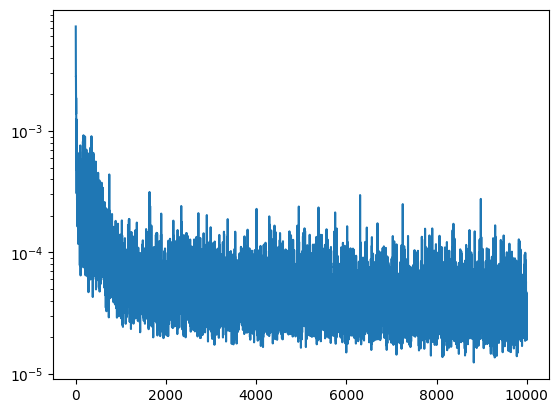

In [14]:
plt.plot(logs["loss_trends_train"])
plt.yscale("log")

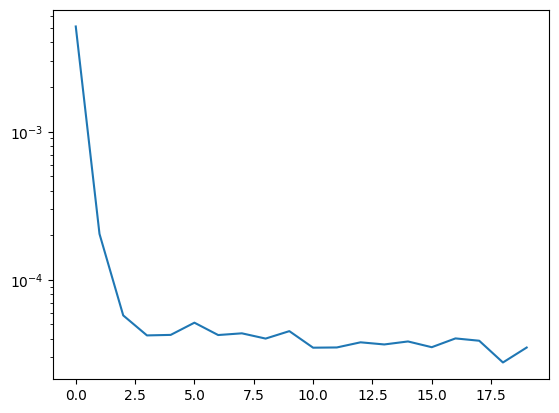

In [15]:
plt.plot(logs["loss_trends_val"])
plt.yscale("log")

In [16]:
from mc2.utils.data_inspection import (
    get_available_material_names, get_file_overview, load_and_process_single_from_full_file_overview,
)
from mc2.utils.data_plotting import plot_single_sequence, plot_hysteresis


In [17]:
frequency_idx=2
batch_idx=jnp.array([1,2,3,4,5,6,7])
H_pred = model(
    B_past=test_set[frequency_idx].B[batch_idx, :15],
    H_past=test_set[frequency_idx].H[batch_idx, :15],
    B_future=test_set[frequency_idx].B[batch_idx, 15:],
    T=test_set[frequency_idx].T[batch_idx]
)#    f=test_set[frequency_idx].frequency
H_pred.shape

(7, 12801)

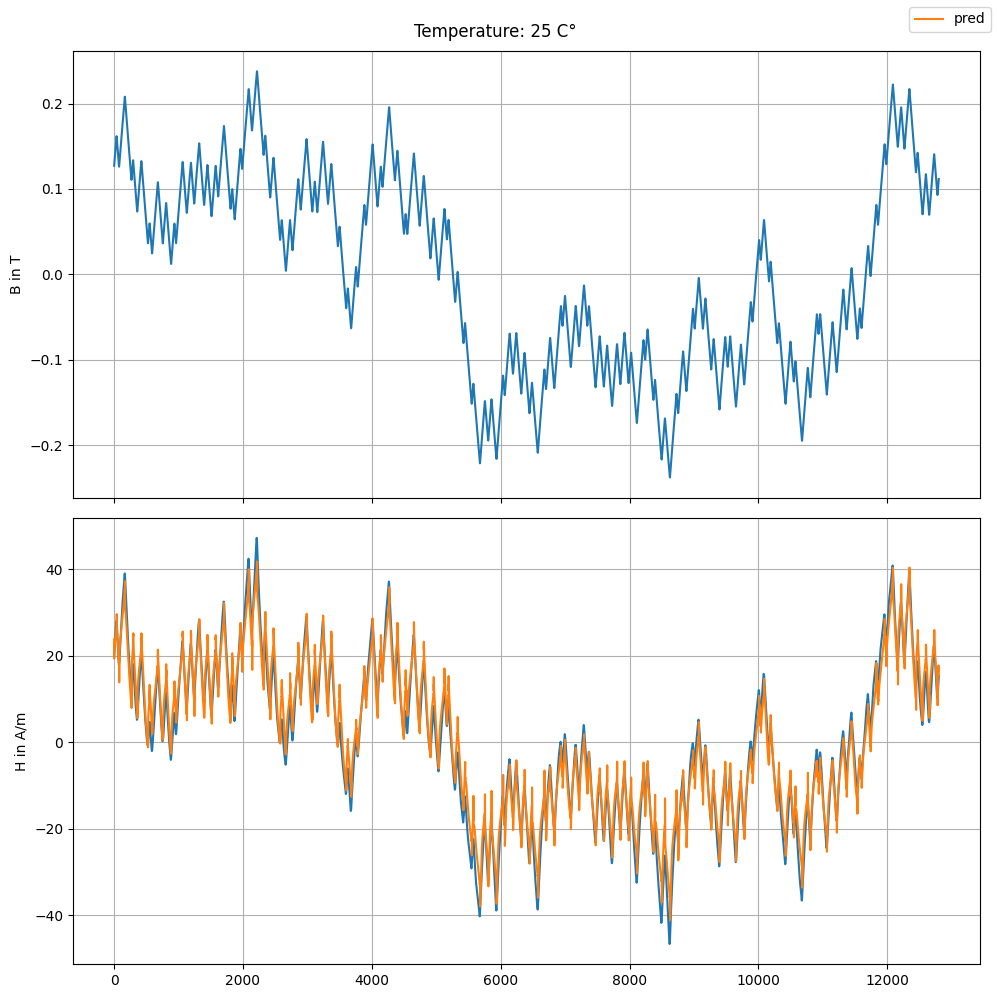

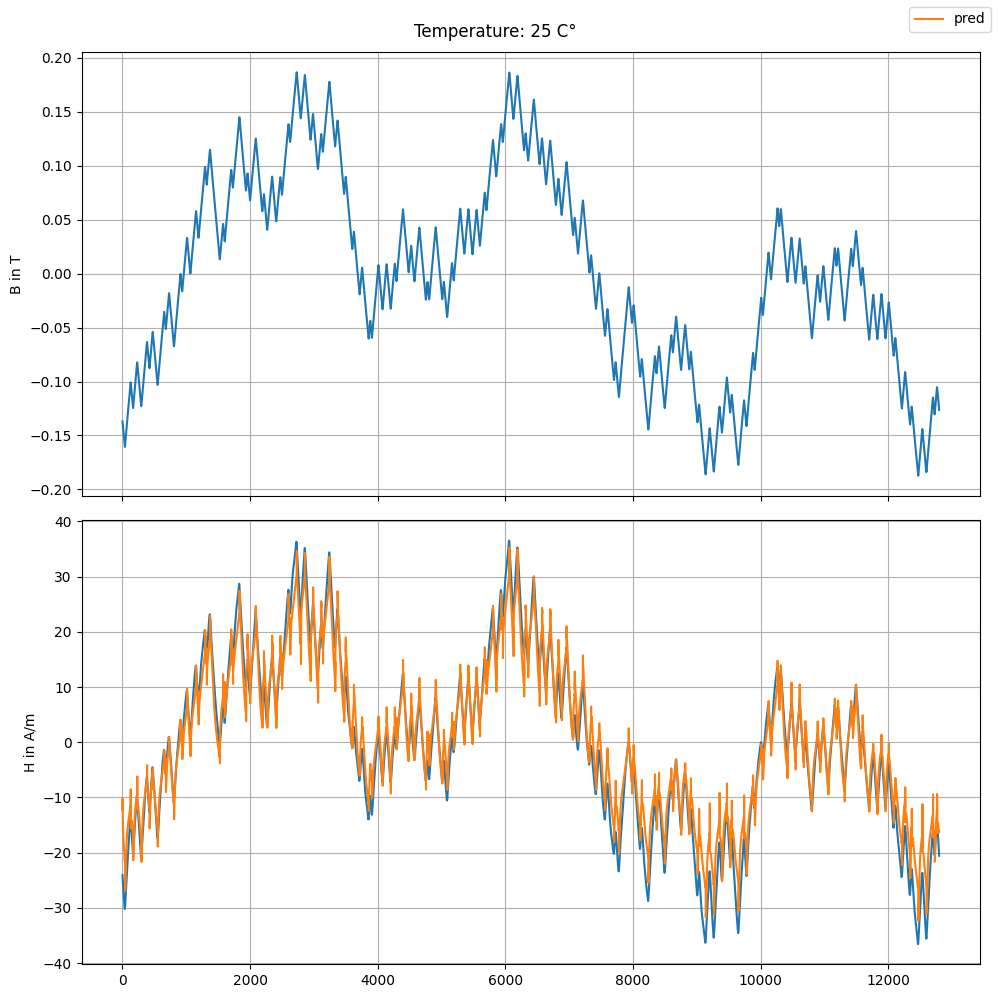

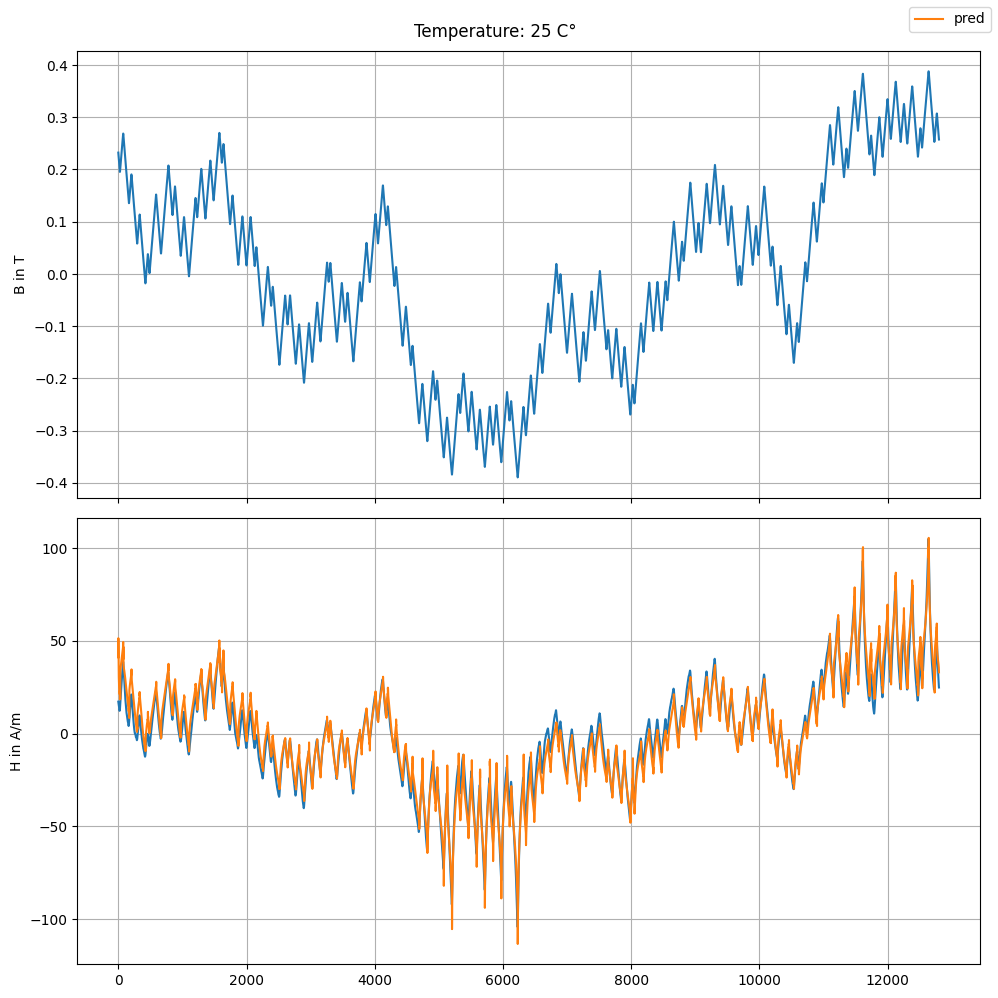

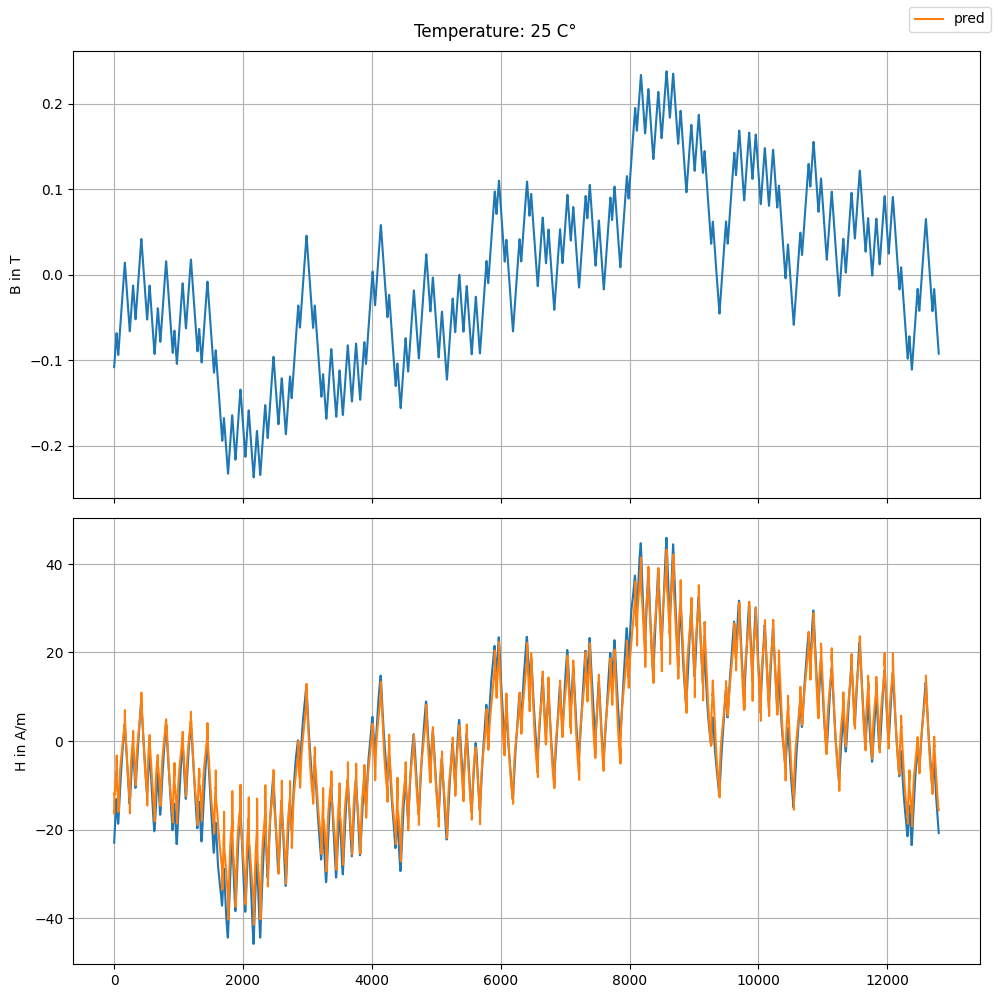

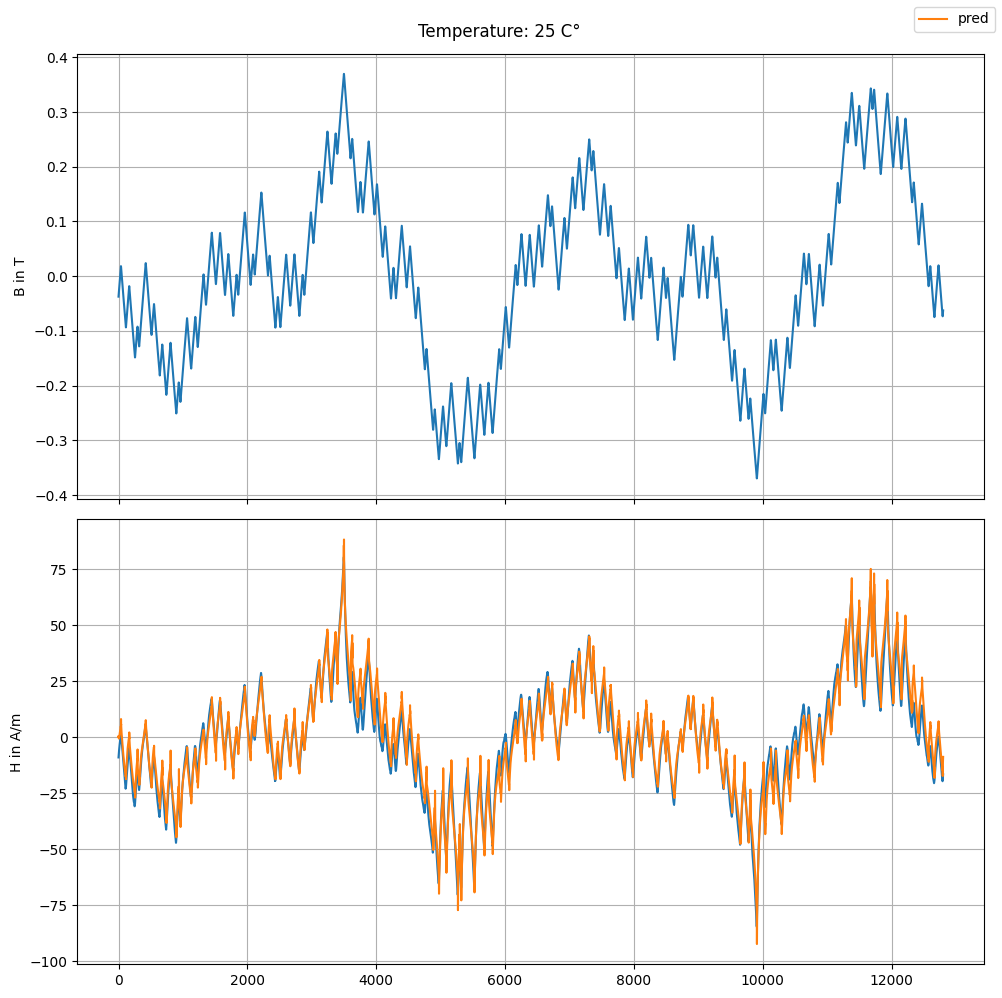

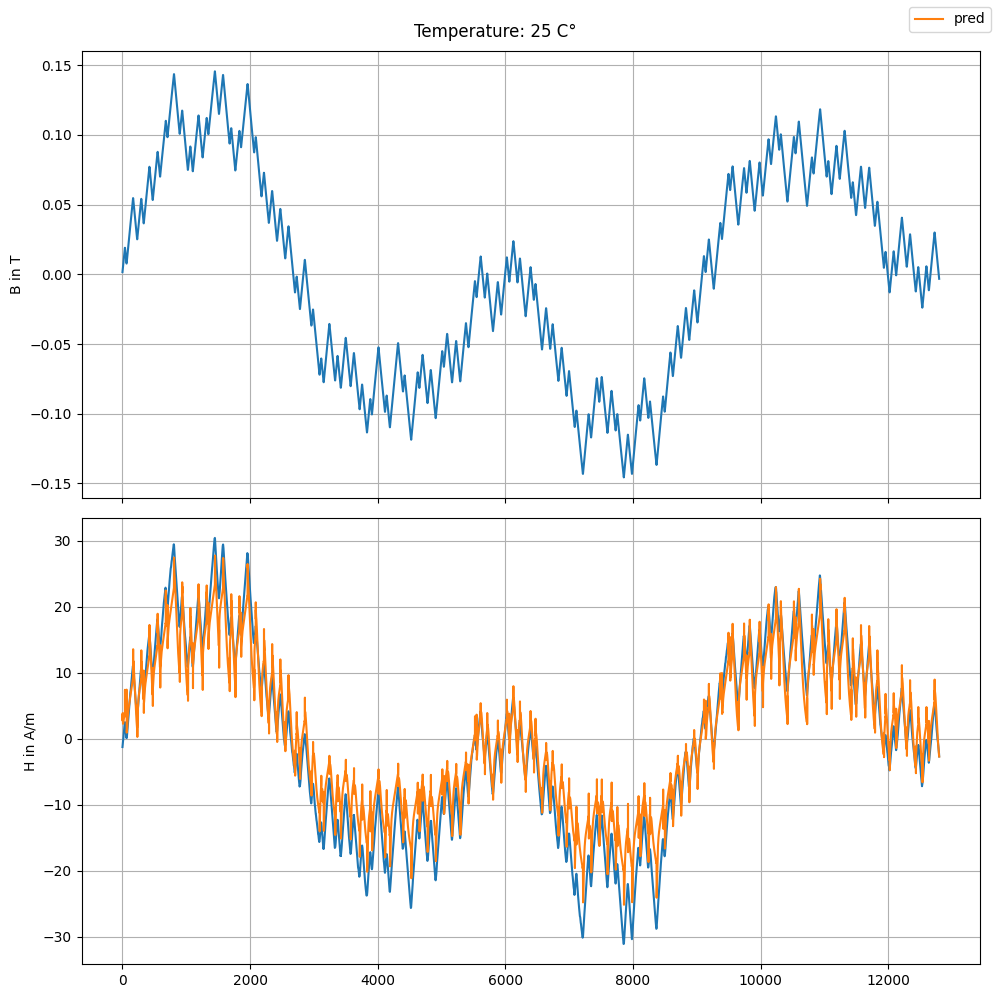

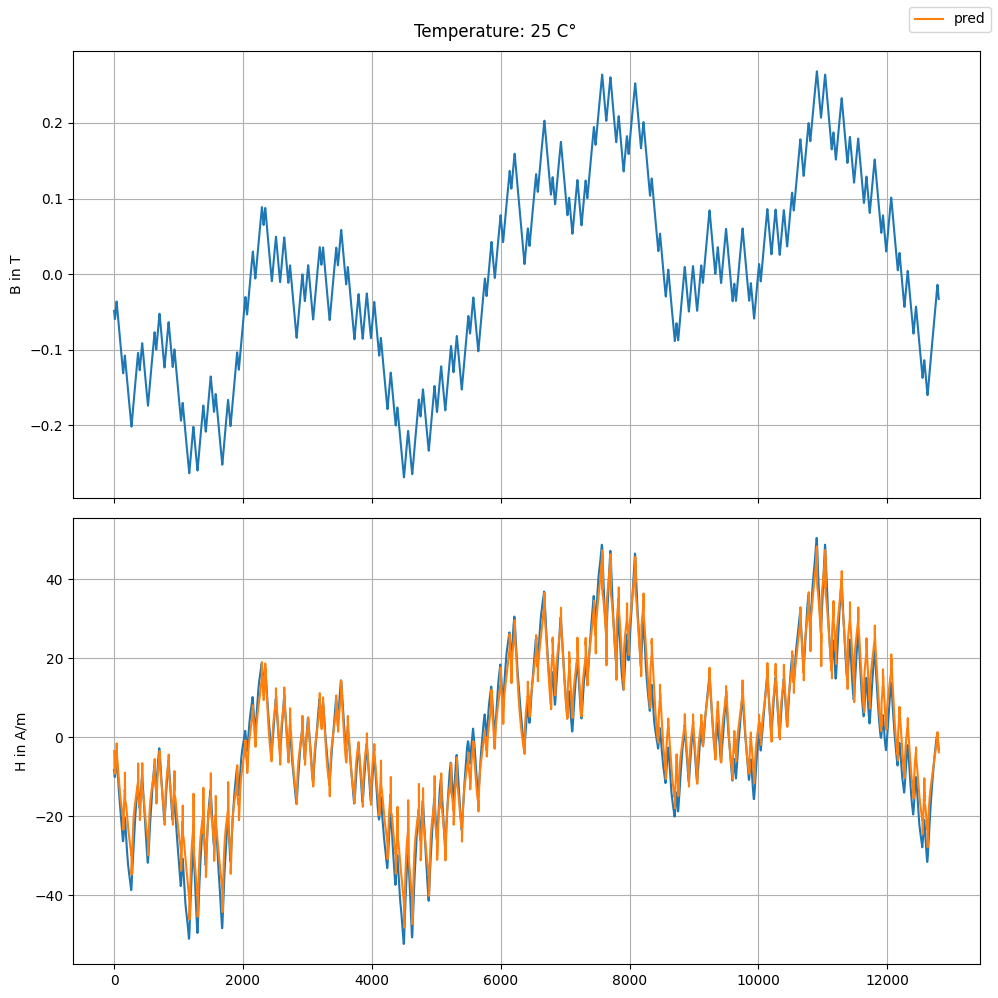

In [18]:
for H_p, H, B,T in zip(H_pred, test_set[frequency_idx].H[batch_idx, 15:], test_set[frequency_idx].B[batch_idx, 15:], test_set[frequency_idx].T[batch_idx]):

    fig, axs = plot_single_sequence(B, H, T)
    axs[-1].plot(H_p, label="pred")
    fig.legend()
    plt.show()